In [1]:
# Fit Forward, 5 day gap

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [3]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [4]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [5]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [6]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [7]:
gap_length = 5

In [65]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, nobad, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    
    if len(primary_river.iloc[spoint-8:spoint]) != 8:
        print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        nobad = nobad + 1
        allbad = True
    else:
        allbad = False
        for ii in range(1, 8):
            jj = ii + gap_length - 1        
            persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
            if ii > 1:
                b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
                linear[ii-2] = b + m * jj
            if ii > 2:
                b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
                cubic[ii-3] = b + m * jj + c * jj**2

        if fittype == 'fit':
            useriver = matching_dictionary[river]
        elif fittype == 'backup':
            useriver = backup_dictionary[river]
        firstchoice = read_river(useriver, 'primary')
        for jj, length in enumerate(fitlength):
            for ii in range(length):
                denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
                if len(denom) == 1:
                    ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                                firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
                else:
                    bad = True
            if not bad:
                numer = firstchoice[firstchoice.index == primary_river.index[point]].values
                if len(numer) != 1:
                    print ('Numer catch')
                    bad = True
                else:
                    fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
        if bad:
            fittedbad = fittedbad + 1
        if doplots:
            ax.plot(persist)
            ax.plot(range(1, 7), linear)
            ax.plot(range(2, 7), cubic)
            if not bad:
                ax.plot(fitted)
            ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
            ax.plot(7, primary_river.iloc[spoint].values, 'x')
            ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
            ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad, allbad, nobad)

In [9]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [10]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [11]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [55]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, nobad, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad, allbad, nobad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, nobad, doplots)

    if not allbad:
        GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
        accumulateG += GG
        accumulateC += CC
        accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad, nobad

In [13]:
print (gap_length)

5


In [24]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

0 Primary River Flow    36.8
Name: 1957-02-08 00:00:00, dtype: float64
0 Primary River Flow    36.8
Name: 1957-02-08 00:00:00, dtype: float64
0 Primary River Flow    36.8
Name: 1957-02-08 00:00:00, dtype: float64
0 Primary River Flow    36.8
Name: 1957-02-08 00:00:00, dtype: float64
0 Primary River Flow    36.8
Name: 1957-02-08 00:00:00, dtype: float64
0 Primary River Flow    36.8
Name: 1957-02-08 00:00:00, dtype: float64
0 Primary River Flow    36.8
Name: 1957-02-08 00:00:00, dtype: float64
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  951.  951.  951.  951.] [ 75.80387666  76.75182237  77.05854413  77.2552471   77.49282486
  78.10417192  79.08525402 175.20766898 159.30635727 148.58282353
 141.71428808 134.25422949 127.11688418 572.72041855 472.60593365
 409.53493381 356.50511721 319.04487837  55.76225854  57.81207033
  60.9370393   65.25847091] [0.076      0.08       0.076      0.073      0.085      0.09
 0.097      0.3

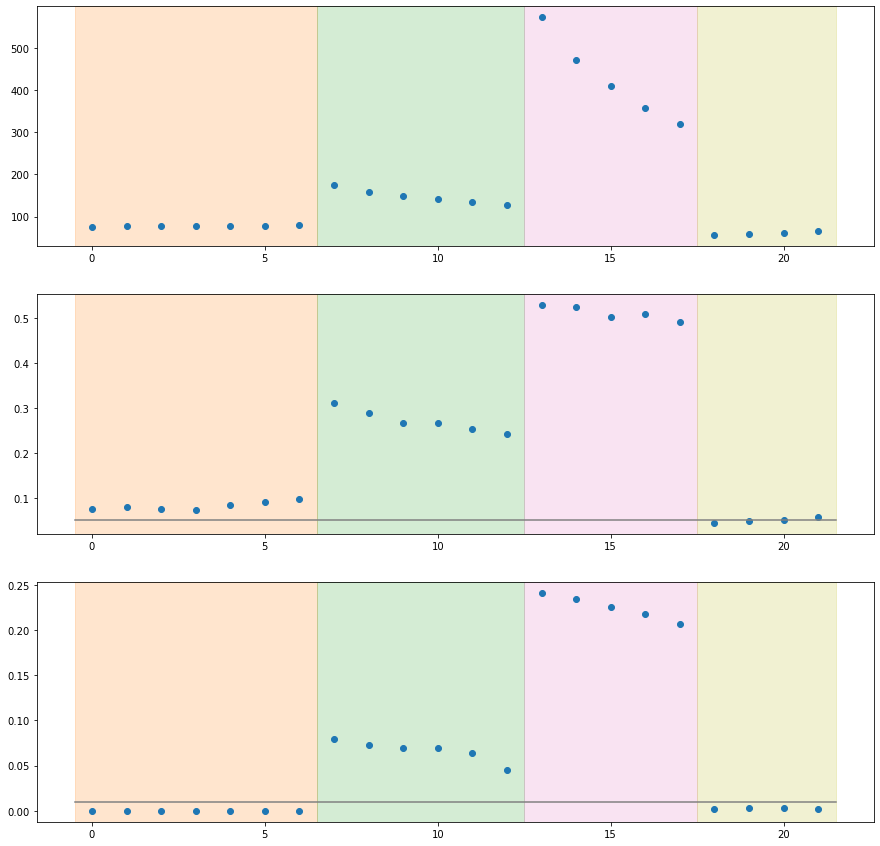

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [20]:
print (gap_length)

5


In [68]:
river = 'Squamish_Brackendale'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

Numer catch
Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  875.  875.  875.  875.] [ 90.93848695  90.86852567  88.74939745  87.41740611  86.59038484
  86.69595782  87.15842962 224.87925137 206.99152096 193.6873169
 177.1903546  162.43190557 152.18926916 883.96348425 594.55355744
 503.30392315 453.78934679 402.92943253  50.14349093  51.98324408
  55.3769962   59.0808624 ] [0.142      0.146      0.147      0.159      0.161      0.155
 0.153      0.505      0.456      0.46       0.441      0.406
 0.391      0.764      0.701      0.678      0.684      0.633
 0.04228571 0.04571429 0.04342857 0.04914286] [0.    0.    0.    0.    0.    0.    0.    0.171 0.143 0.136 0.123 0.104
 0.1   0.375 0.31  0.304 0.297 0.271 0.    0.    0.    0.   ]


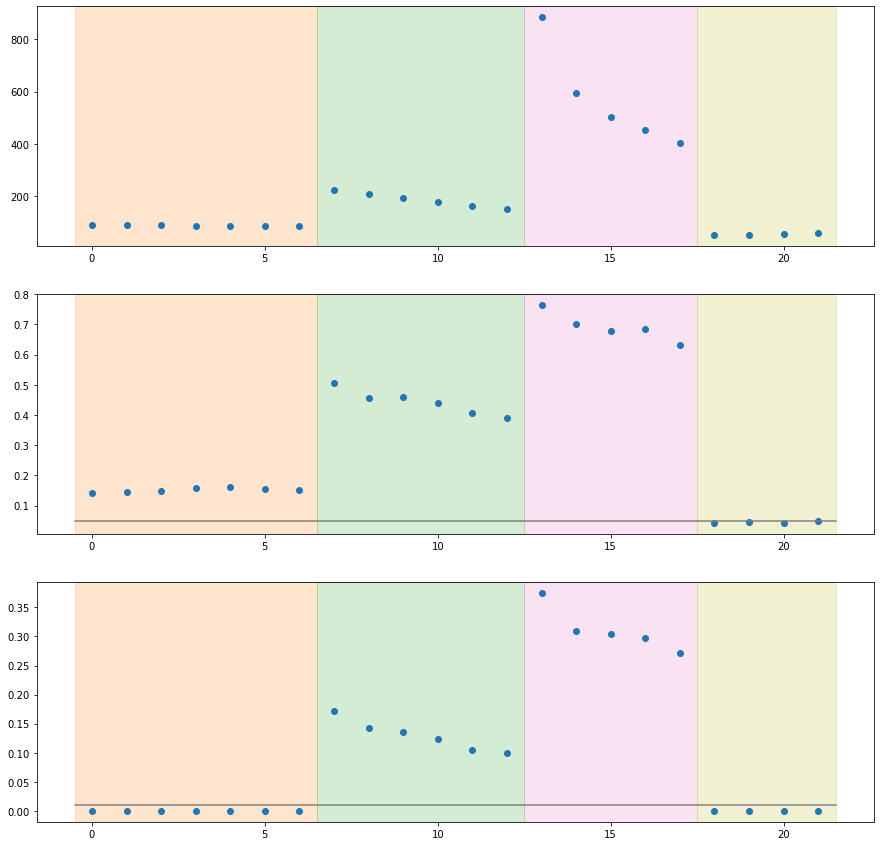

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [22]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [ 123.93113336  123.45692808  123.8535667   123.46372388  123.50971934
  124.07502765  124.96944405  308.44245403  280.7653282   249.63447692
  242.45896611  235.4133327   223.42188118 1053.54195127  861.67054053
  716.16568192  606.84752632  536.37648692   61.91660409   64.21613389
   64.25304701   67.02598805] [0.152      0.142      0.15       0.155      0.156      0.161
 0.164      0.456      0.429      0.412      0.425      0.387
 0.375      0.608      0.605      0.583      0.587      0.572
 0.02805611 0.02805611 0.0260521  0.02905812] [0.         0.         0.         0.         0.         0.
 0.         0.134      0.119      0.1        0.095      0.098
 0.088      0.301      0.277      0.264      0.248      0.236
 0.001002   0.001002   0.00200401 0.001002  ]


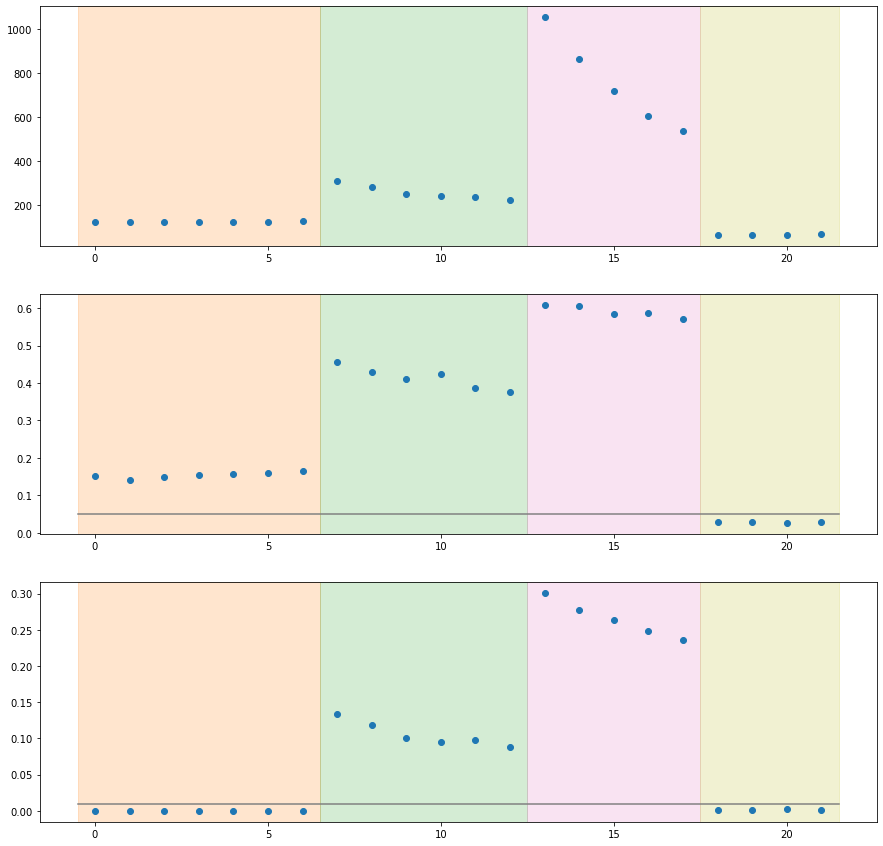

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [28]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [ 130.8615611   131.5895825   132.48080807  133.90313777  135.71636176
  137.65839335  139.69931394  331.2788067   277.78459977  257.56383418
  241.89665666  229.83530166  219.03376657 1237.3684842   875.9757918
  675.61806063  592.21712853  544.58940353  133.00664006  143.81281468
  151.84299361  159.02398153] [0.054      0.055      0.054      0.056      0.058      0.055
 0.059      0.341      0.281      0.26       0.236      0.212
 0.202      0.692      0.626      0.556      0.499      0.493
 0.03306613 0.03907816 0.04208417 0.0501002 ] [0.         0.         0.         0.         0.         0.
 0.         0.136      0.092      0.081      0.068      0.066
 0.06       0.358      0.31       0.278      0.252      0.24
 0.001002   0.00200401 0.00200401 0.00200401]


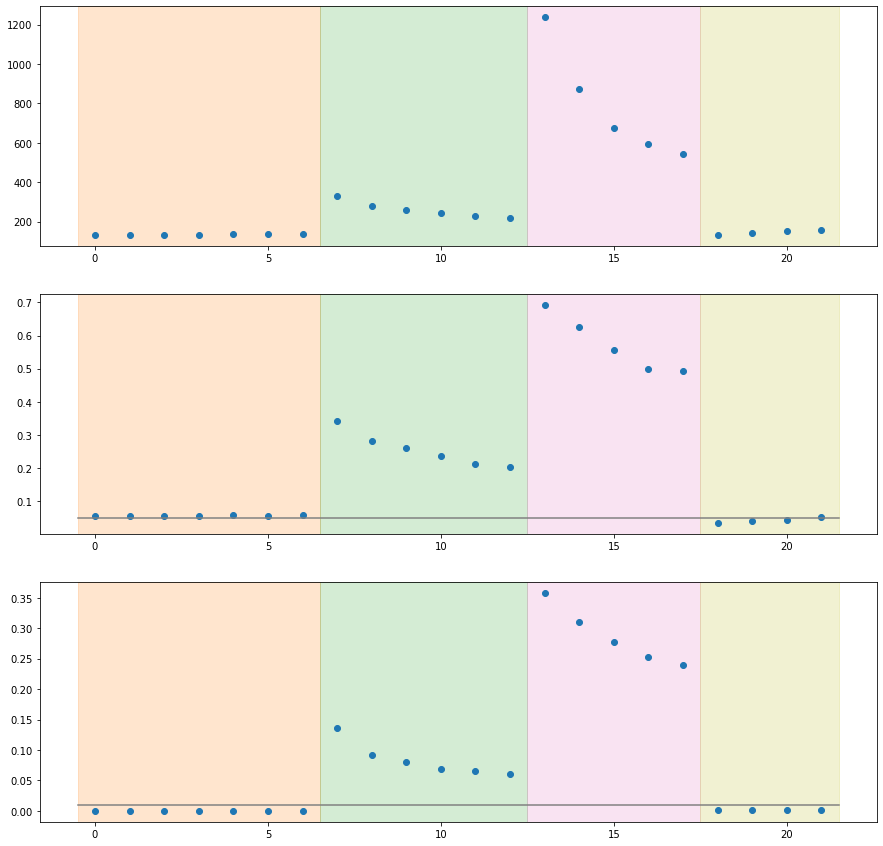

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [59]:
river = 'Nisqually_McKenna'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

0 Primary River Flow    14.24335
Name: 1977-05-31 00:00:00, dtype: float64
realized 999
[999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.
 999. 999. 999. 999. 999. 999. 999. 999.] [ 13.55246585  13.73918966  13.65589734  13.69173264  13.68050648
  13.78175925  13.91310109  28.40121024  27.35397223  26.00237639
  25.42428241  25.07475458  24.13394687 115.10571231  80.80072872
  66.0792731   59.15107033  51.75156131  13.32813971  13.82583698
  14.59680392  15.79019001] [0.08808809 0.09309309 0.09109109 0.0960961  0.0980981  0.0960961
 0.0960961  0.24424424 0.23823824 0.22322322 0.22322322 0.21821822
 0.21721722 0.4954955  0.45445445 0.41541542 0.40540541 0.4014014
 0.10810811 0.11611612 0.11811812 0.13413413] [0.         0.         0.         0.         0.         0.
 0.         0.06006006 0.05005005 0.05205205 0.05005005 0.04104104
 0.03903904 0.23423423 0.2032032  0.15115115 0.14414414 0.13213213
 0.         0.         0.         0.        ]


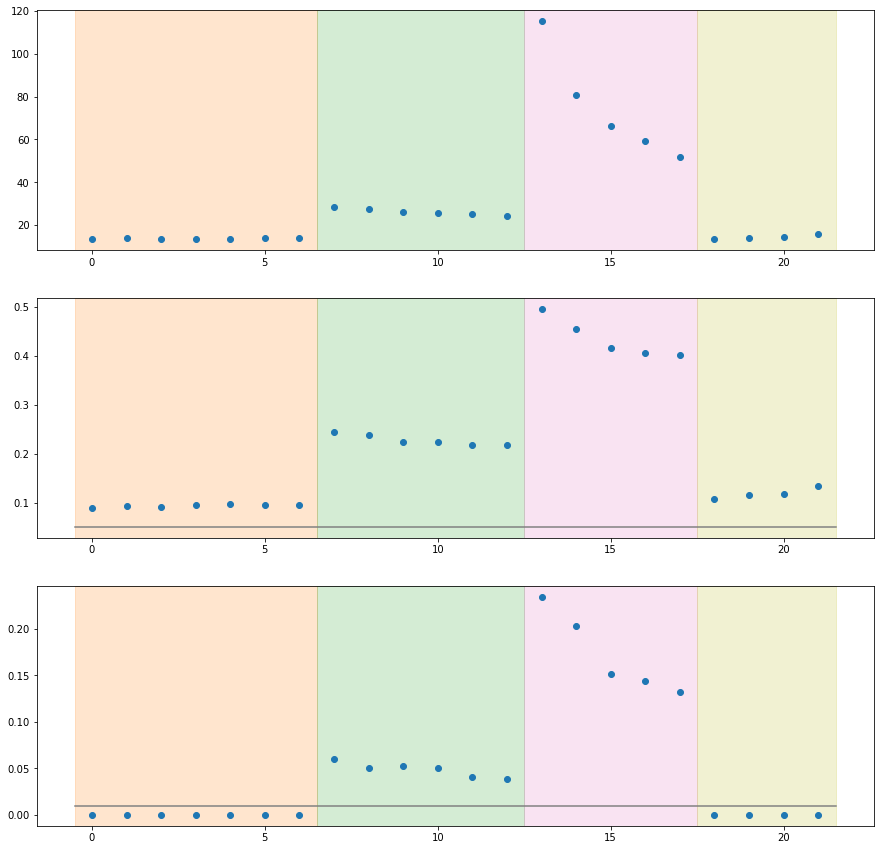

In [61]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [36]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [ 1.85343084  1.96294747  2.03930229  2.08121327  2.12265278  2.17178382
  2.22400668  3.21540326  2.92841107  3.05883576  3.12962882  3.14421245
  3.12972038 10.7967018   8.84078796  7.92958036  6.70311763  6.20937266
  1.20005116  1.27014784  1.32364335  1.38601688] [0.065      0.073      0.074      0.081      0.084      0.086
 0.09       0.18       0.184      0.191      0.186      0.178
 0.178      0.409      0.364      0.368      0.348      0.34
 0.02905812 0.03106212 0.03707415 0.04008016] [0.         0.         0.         0.         0.         0.
 0.         0.036      0.043      0.033      0.037      0.03
 0.029      0.174      0.144      0.142      0.152      0.155
 0.001002   0.00200401 0.00200401 0.001002  ]


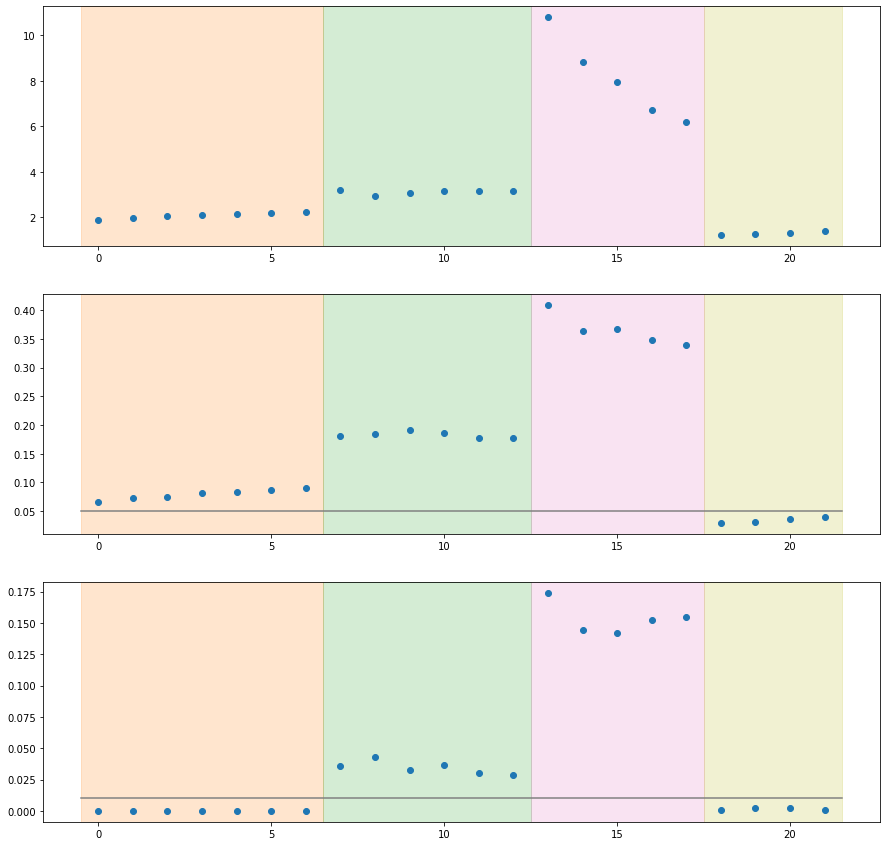

In [37]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [66]:
river = 'Clowhom_ClowhomLake'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
nobad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad, nobad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', nobad, doplots=False)
    
print ("realized", number_trys - nobad)

number_good = (number_trys - nobad) * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

Numer catch
Numer catch
realized 1000
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  761.  761.  761.  761.] [  9.1271329    9.28981693   9.30315432   9.27636568   9.14505506
   8.91333358   8.77094639  28.98938816  24.06756876  20.88709743
  19.14754245  17.94463922  17.09694602 125.89556634  87.3399708
  63.30529797  54.19672247  45.31643111   7.68306688   8.08162334
   8.88232016   9.52510809] [0.253      0.257      0.254      0.261      0.268      0.265
 0.277      0.581      0.584      0.549      0.524      0.527
 0.525      0.749      0.729      0.716      0.718      0.7
 0.12483574 0.12877792 0.13797635 0.17345598] [0.         0.         0.         0.         0.         0.
 0.         0.259      0.22       0.201      0.188      0.171
 0.161      0.354      0.352      0.328      0.321      0.303
 0.01051248 0.00525624 0.00919842 0.00788436]


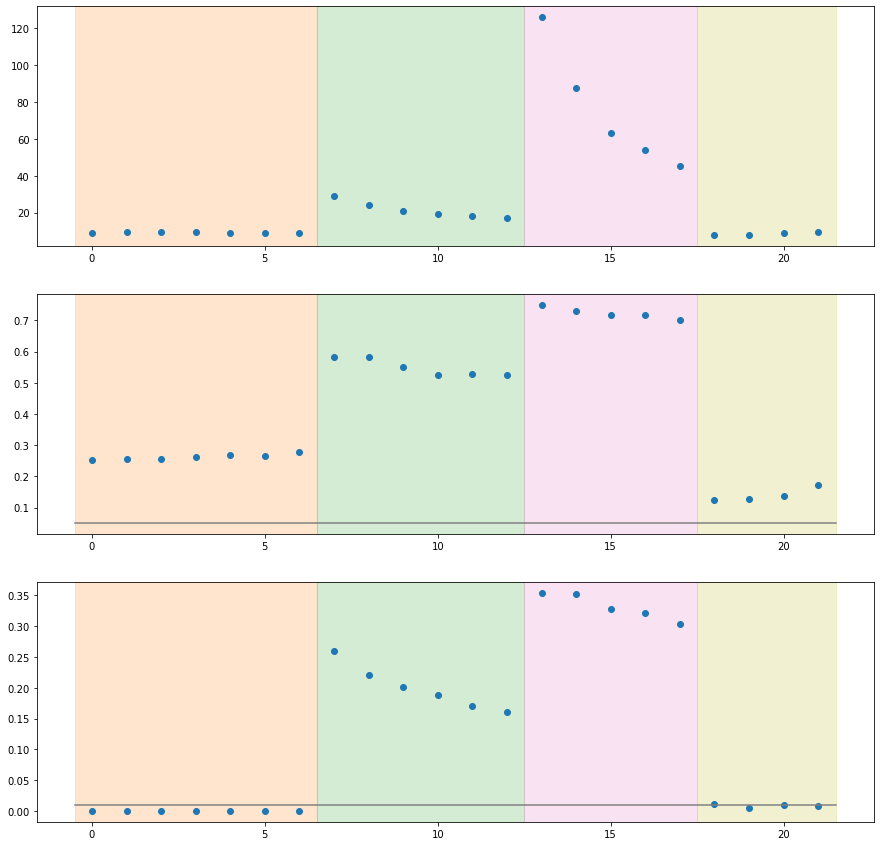

In [67]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');